In [33]:
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [34]:
# Reading dataset
df = pd.read_csv("METR-LA.csv")

# Converting timestamp to datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Seting timestamp as index
df = df.set_index('timestamp')


In [35]:
train_ratio = 0.8
train_size = int(len(df) * train_ratio)
train_df = df[:train_size]
test_df = df[train_size:]


In [36]:
class RNN:

    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, inputs, h_prev):
        h = np.tanh(np.dot(self.Wxh, inputs) + np.dot(self.Whh, h_prev) + self.bh)
        y = np.dot(self.Why, h) + self.by
        return h, y

    def predict(self, inputs, h_prev):
        _, y = self.forward(inputs, h_prev)
        return y


In [37]:
def train_rnn(rnn, train_data, learning_rate, epochs):
    input_size = train_data.shape[1]
    output_size = train_data.shape[1]
    hidden_size = rnn.hidden_size

    # Initialize hidden state
    h_prev = np.zeros((hidden_size, 1))

    for epoch in range(epochs):
        loss = 0
        for i in range(train_data.shape[0] - 1):
            inputs = train_data[i].reshape(input_size, 1)
            targets = train_data[i + 1].reshape(output_size, 1)

            # Forward pass
            h, y = rnn.forward(inputs, h_prev)

            # Compute loss
            loss += 0.5 * np.sum((y - targets) ** 2)

            # Backward pass
            dy = y - targets
            dWhy = np.dot(dy, h.T)
            dby = dy

            dh = np.dot(rnn.Why.T, dy)
            dh = (1 - h * h) * dh

            dWxh = np.dot(dh, inputs.T)
            dWhh = np.dot(dh, h_prev.T)
            dbh = dh

            # Update weights
            rnn.Wxh -= learning_rate * dWxh
            rnn.Whh -= learning_rate * dWhh
            rnn.Why -= learning_rate * dWhy
            rnn.bh -= learning_rate * dbh
            rnn.by -= learning_rate * dby

            h_prev = h

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, Loss: {loss:.4f}")


In [38]:
# Initializing RNN
input_size = train_df.shape[1]
hidden_size = 10
output_size = train_df.shape[1]
rnn = RNN(input_size, hidden_size, output_size)

# Normalizing the data
train_mean = train_df.mean()
train_std = train_df.std()
train_data = (train_df - train_mean) / train_std

# Training the model
learning_rate = 0.001
epochs = 100
train_rnn(rnn, train_data.values, learning_rate, epochs)


Epoch: 10, Loss: 718800.6214
Epoch: 20, Loss: 702896.0253
Epoch: 30, Loss: 710382.3299
Epoch: 40, Loss: 687570.9409
Epoch: 50, Loss: 704396.6951
Epoch: 60, Loss: 709181.2279
Epoch: 70, Loss: 684511.0354
Epoch: 80, Loss: 680059.4332
Epoch: 90, Loss: 671683.3644
Epoch: 100, Loss: 695210.9850


In [39]:
# Normalizing the test data
test_data = (test_df - train_mean) / train_std

# Initializing hidden state
h_prev = np.zeros((hidden_size, 1))

# Predicting and de-normalizing the output
predictions = []
for i in range(test_data.shape[0] - 1):
    inputs = test_data.iloc[i].values.reshape(input_size, 1)
    h, pred = rnn.forward(inputs, h_prev)  # Use forward method here
    pred = (pred * train_std.values.reshape(-1, 1)) + train_mean.values.reshape(-1, 1)
    predictions.append(pred.flatten())
    h_prev = h

predictions = np.array(predictions)


In [40]:
mae = mean_absolute_error(test_df.iloc[1:], predictions)
print(f"Mean Absolute Error: {mae:.4f}")

mse = mean_squared_error(test_df.iloc[1:], predictions)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.4f}")

r2 = r2_score(test_df.iloc[1:], predictions)
print(f"R-squared: {r2:.4f}")


Mean Absolute Error: 6.8954
Root Mean Squared Error: 12.5164
R-squared: 0.6959


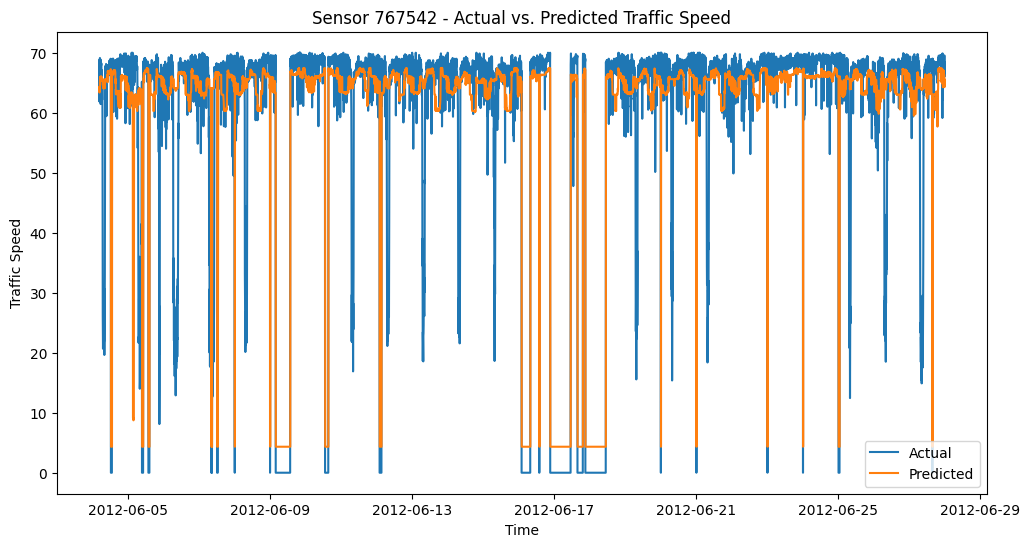

In [41]:
sensor_id = "767542"
plt.figure(figsize=(12, 6))
plt.plot(test_df[sensor_id].iloc[1:], label="Actual")
plt.plot(test_df.index[1:], predictions[:, test_df.columns.get_loc(sensor_id) - 1], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Traffic Speed")
plt.title(f"Sensor {sensor_id} - Actual vs. Predicted Traffic Speed")
plt.legend()
plt.show()


In [42]:
def predict_future(rnn, initial_data, n_steps, hidden_size):
    predictions = []

    # Initialize hidden state
    h_prev = np.zeros((hidden_size, 1))

    # Predict iteratively
    for _ in range(n_steps):
        h, pred = rnn.forward(initial_data, h_prev)
        predictions.append(pred.flatten())
        initial_data = pred
        h_prev = h

    return np.array(predictions)


In [43]:
# Normalizing the last data point from the test set
initial_data = (test_df.iloc[-1] - train_mean) / train_std
initial_data = initial_data.values.reshape(input_size, 1)

n_steps = 12
future_predictions = predict_future(rnn, initial_data, n_steps, hidden_size)

# De-normalizing the output
future_predictions = (future_predictions * train_std.values) + train_mean.values


In [44]:
no_threshold=0
low_threshold = 30
medium_threshold = 50
given_time_index = 50  # Replace this with the desired index from the test dataset
traffic_speeds = test_df.iloc[given_time_index].values

future_time_index = 5  # Replace this with the desired index from the future_predictions
future_traffic_speeds = future_predictions[future_time_index]


In [45]:
def classify_traffic(sensor_ids, speeds, low_threshold, medium_threshold, no_threshold):
    traffic_levels = {}

    for sensor_id, speed in zip(sensor_ids, speeds):
        if speed == no_threshold:
            traffic_levels[sensor_id] = "no Traffic"
        elif speed >= medium_threshold:
            traffic_levels[sensor_id] = "Low"
        elif speed <= medium_threshold and speed >= low_threshold:
            traffic_levels[sensor_id] = "Medium"
        else:
            traffic_levels[sensor_id] = "High"

    return traffic_levels

In [46]:
traffic_levels = classify_traffic(test_df.columns, traffic_speeds, low_threshold, medium_threshold, no_threshold)

print("Low Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "Low"])

print("\nNo Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "no Traffic"])

print("\nMedium Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "Medium"])

print("\nHigh Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "High"])


Low Traffic Sensors:
['773869', '767541', '767542', '717447', '717445', '773062', '767620', '737529', '767471', '773906', '769953', '769402', '769819', '717578', '717804', '767572', '767573', '773013', '764424', '717819', '769941', '760987', '718204', '769418', '773927', '774012', '774011', '767609', '769831', '773953', '767470', '764949', '767366', '773939', '774067', '769443', '767750', '767751', '767610', '773880', '717497', '717491', '717492', '765176', '717498', '718066', '765164', '769431', '717610', '767621', '772596', '767351', '716571', '767585', '773024', '717483', '717480', '764120', '717818', '718076', '718072', '767455', '767454', '761599', '773916', '716968', '769467', '717573', '717572', '717571', '717570', '764760', '769847', '767523', '769867', '717473', '759591', '764781', '765099', '762329', '767509', '769358', '772513', '718496', '773904', '718499', '761003', '717502', '759602', '763995', '773996', '773995', '717469', '764106', '717465', '764794', '717460', '717463'

In [47]:
future_traffic_levels = classify_traffic(test_df.columns, future_traffic_speeds, low_threshold, medium_threshold, no_threshold)

print("Low Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "Low"])

print("\nNo Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "no Traffic"])

print("\nMedium Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "Medium"])

print("\nHigh Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "High"])


Low Traffic Sensors:
['773869', '767541', '767542', '717447', '717446', '773062', '767620', '737529', '717816', '765604', '767471', '716339', '773906', '765273', '716331', '716337', '769953', '769402', '769403', '769819', '769405', '716941', '717578', '716960', '717804', '767572', '767573', '773012', '773013', '764424', '769388', '716328', '717819', '769941', '760987', '718204', '718045', '769418', '768066', '772140', '773927', '760024', '774012', '774011', '767609', '769359', '760650', '716956', '769831', '761604', '717495', '716554', '773953', '767470', '716955', '764949', '773954', '767366', '769444', '773939', '774067', '769443', '767750', '767751', '767610', '773880', '764766', '717497', '717490', '717491', '717492', '717493', '765176', '717498', '717499', '765171', '718064', '718066', '765164', '769431', '769430', '717610', '767053', '767621', '772596', '772597', '767350', '767351', '716571', '773023', '767585', '773024', '717483', '718379', '717480', '717486', '764120', '772151'

In [48]:
def plot_traffic_levels_group(sensor_ids, traffic_levels, title):
    plt.figure(figsize=(15, 6))
    plt.title(title)
    
    unique_levels = ["no Traffic", "Low", "Medium", "High"]
    level_values = {"no Traffic": 0, "Low": 1, "Medium": 2, "High": 3}
    
    sorted_sensor_ids = sorted(sensor_ids)
    
    single_color = "blue"
    
    for i, (sensor_id, level) in enumerate(traffic_levels.items()):
        label = level if i == 0 else None
        plt.scatter(sensor_id, level_values[level], color=single_color, label=label, s=100)

    plt.xlabel("Sensor ID")
    plt.ylabel("Traffic Level")
    plt.yticks(range(4), unique_levels)
    plt.legend()
    plt.show()



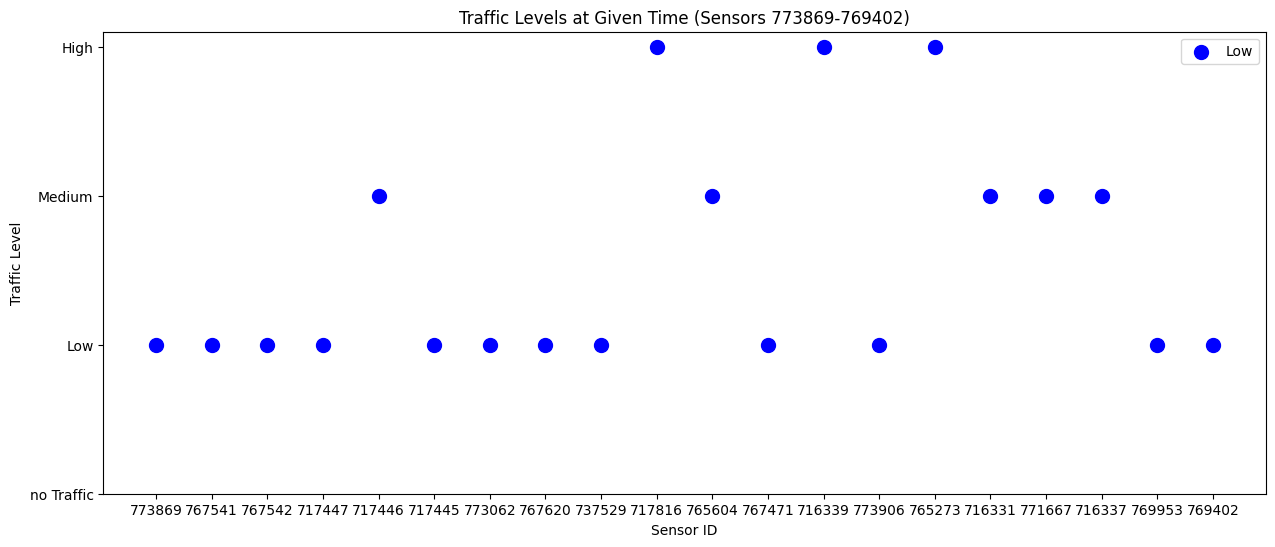

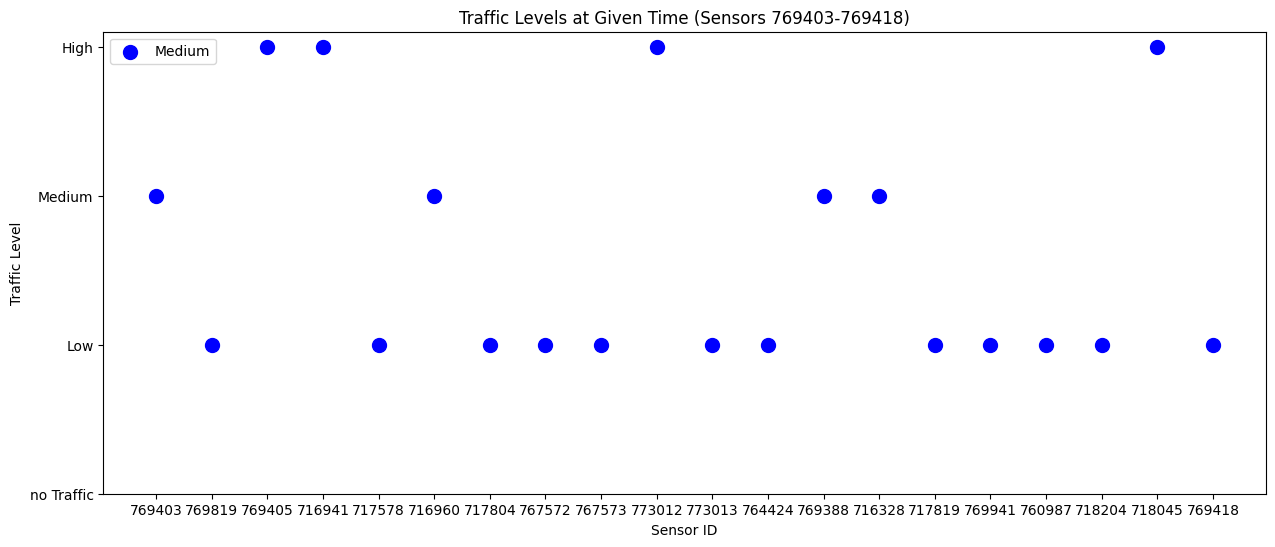

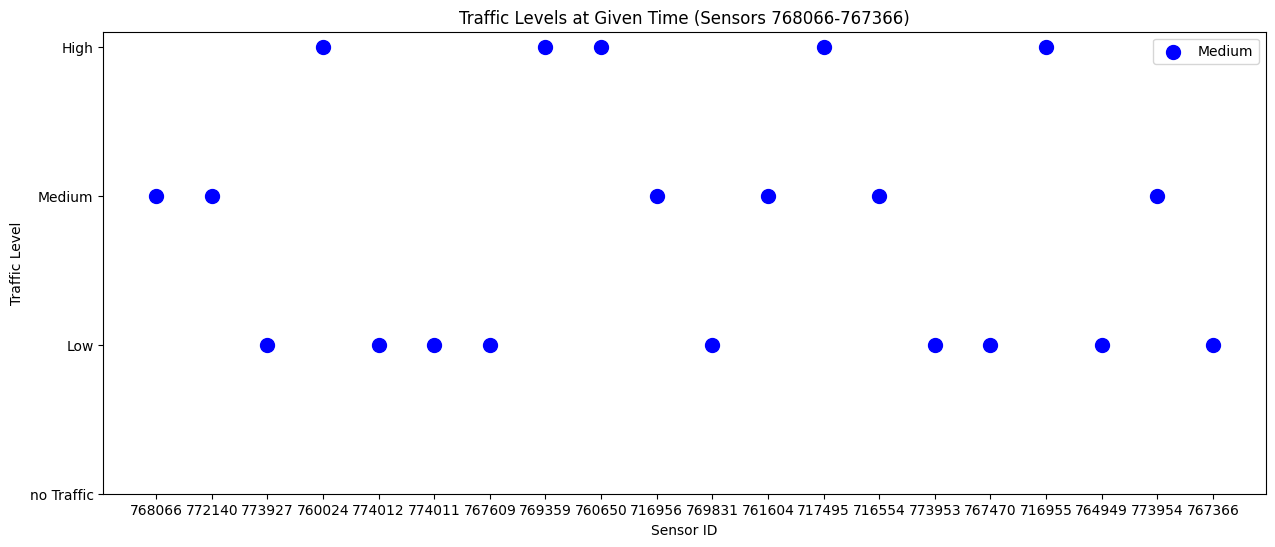

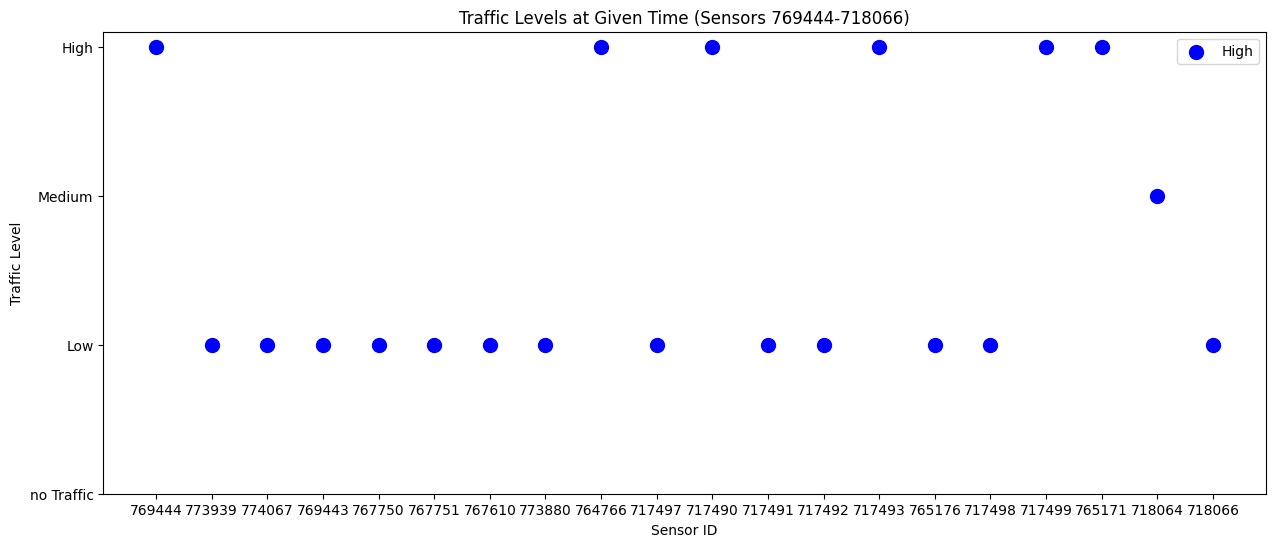

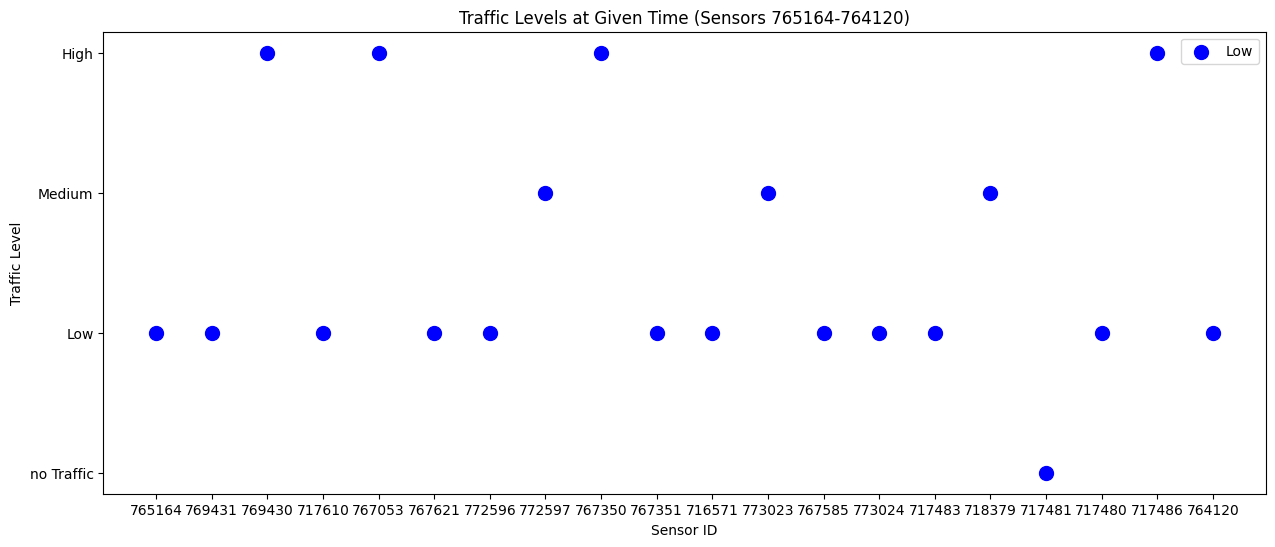

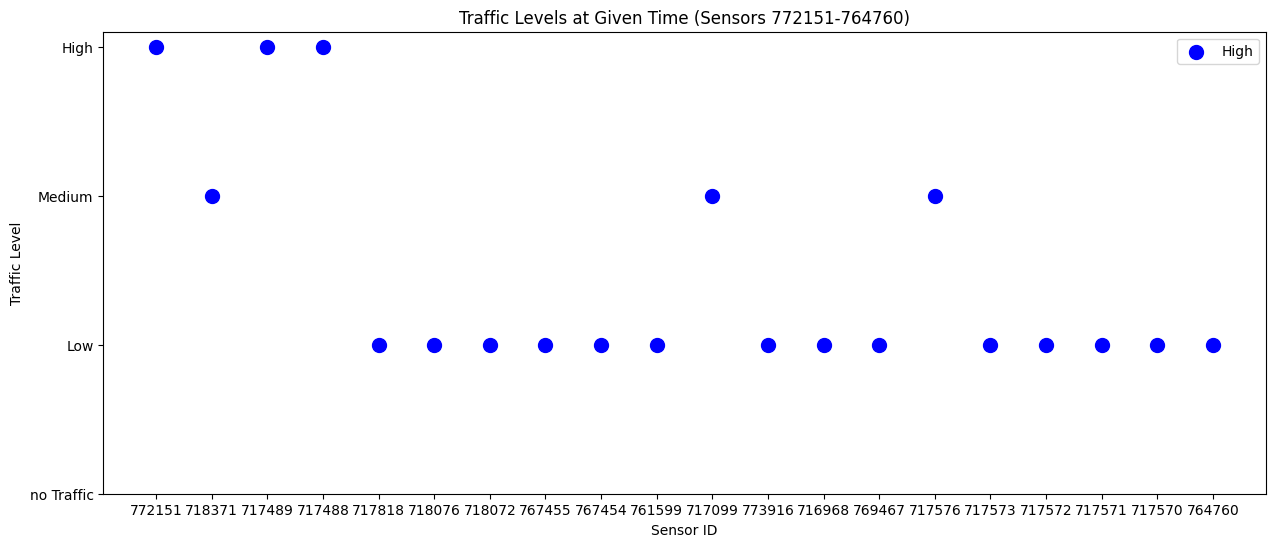

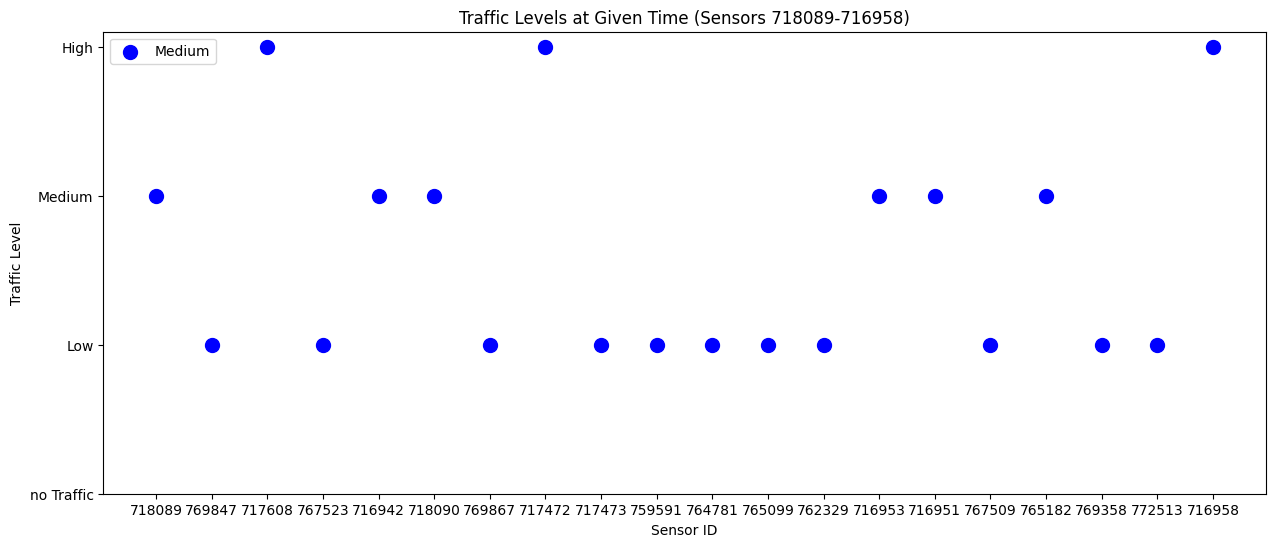

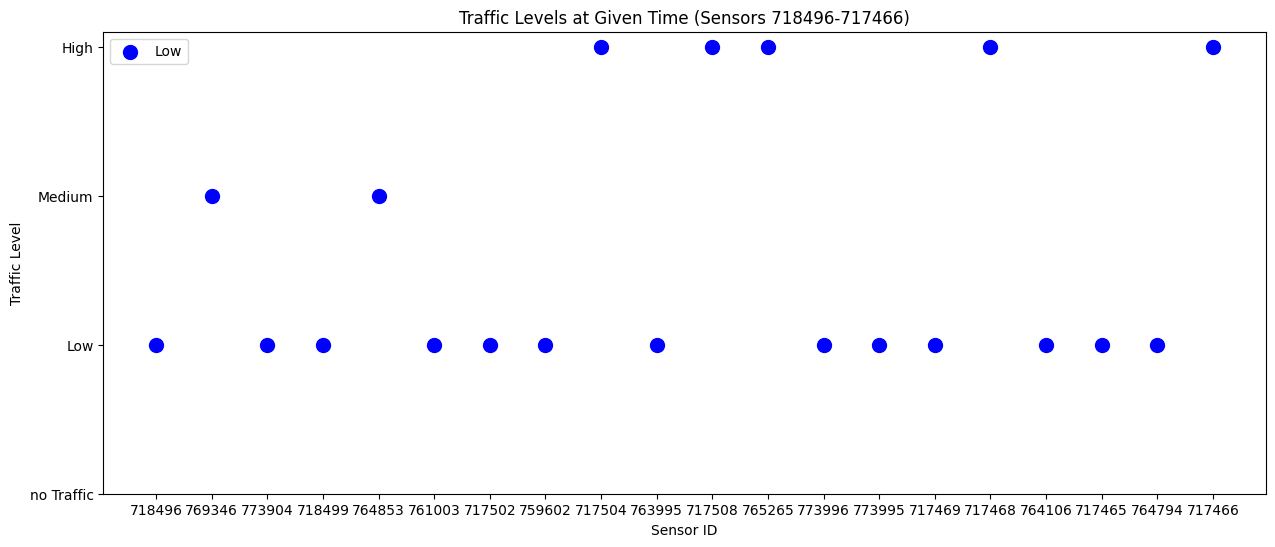

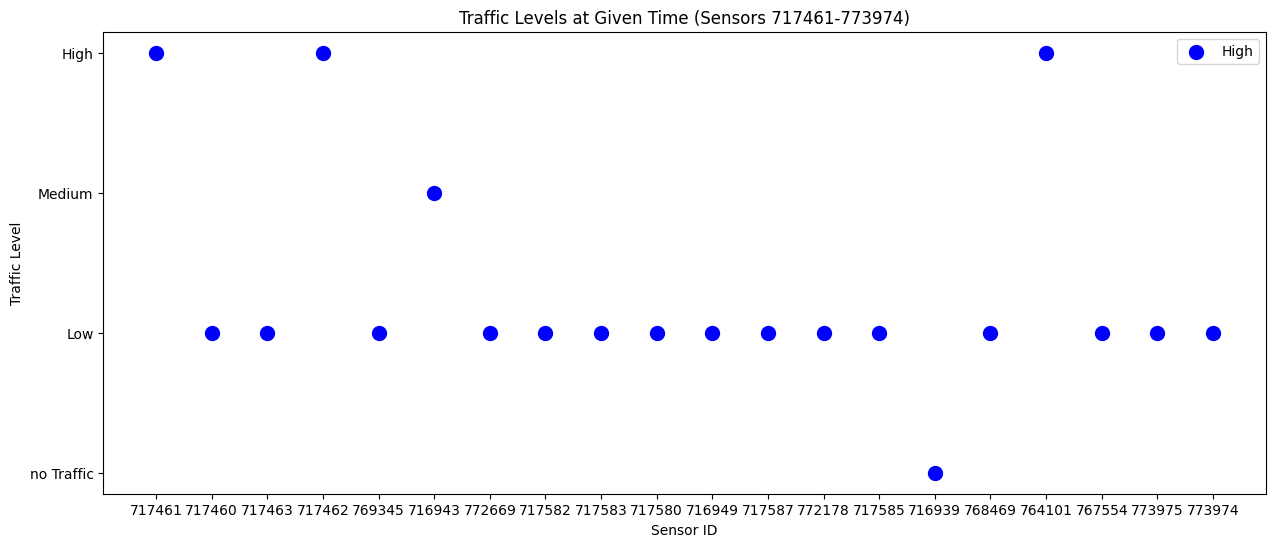

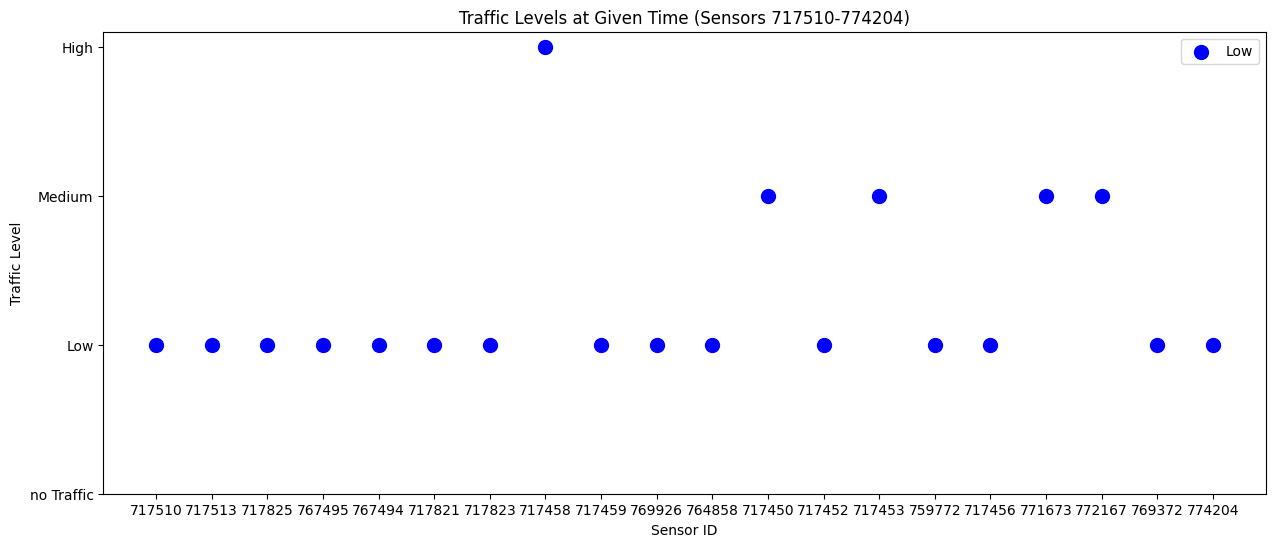

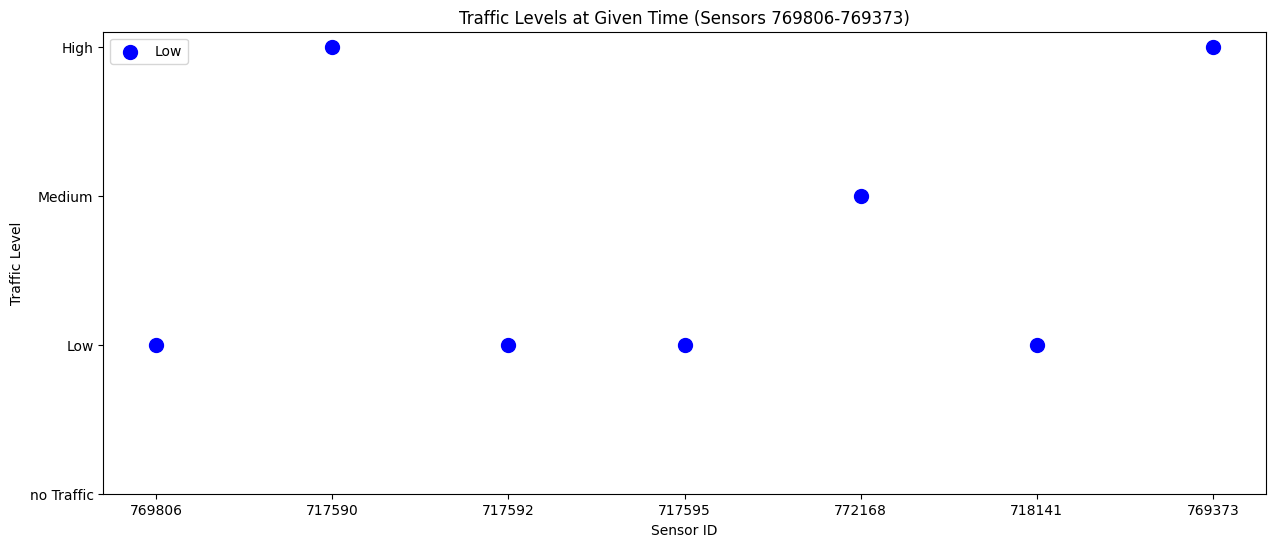

In [49]:
sensors_per_plot = 20

for i in range(0, len(test_df.columns), sensors_per_plot):
    sensor_group = test_df.columns[i: i + sensors_per_plot]
    traffic_levels_group = {sensor_id: traffic_levels[sensor_id] for sensor_id in sensor_group}
    
    plot_traffic_levels_group(sensor_group, traffic_levels_group, f"Traffic Levels at Given Time (Sensors {sensor_group[0]}-{sensor_group[-1]})")


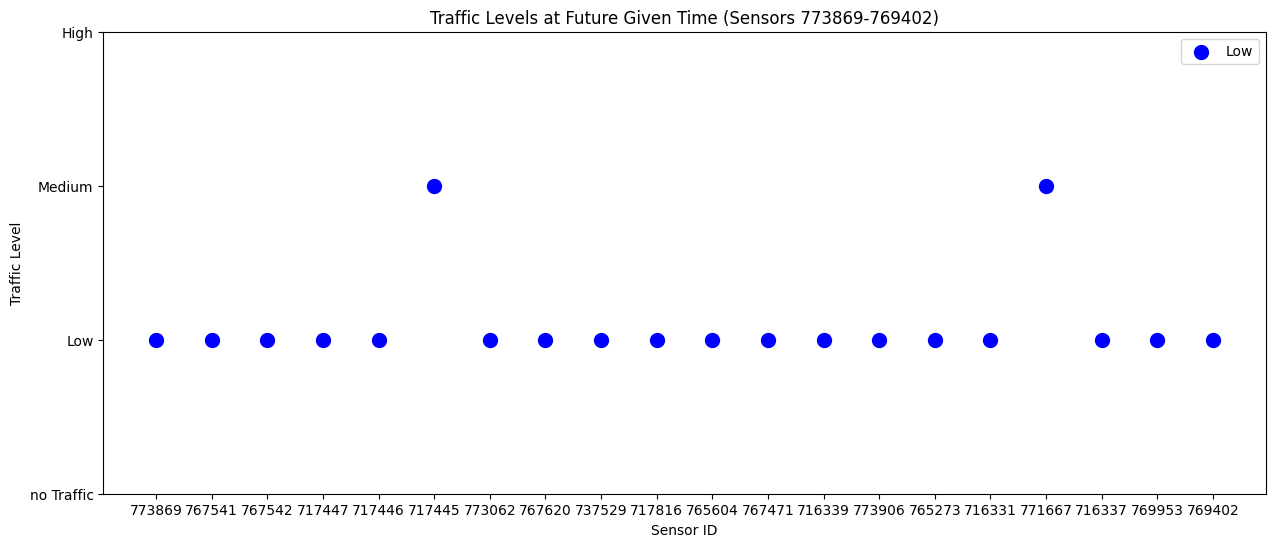

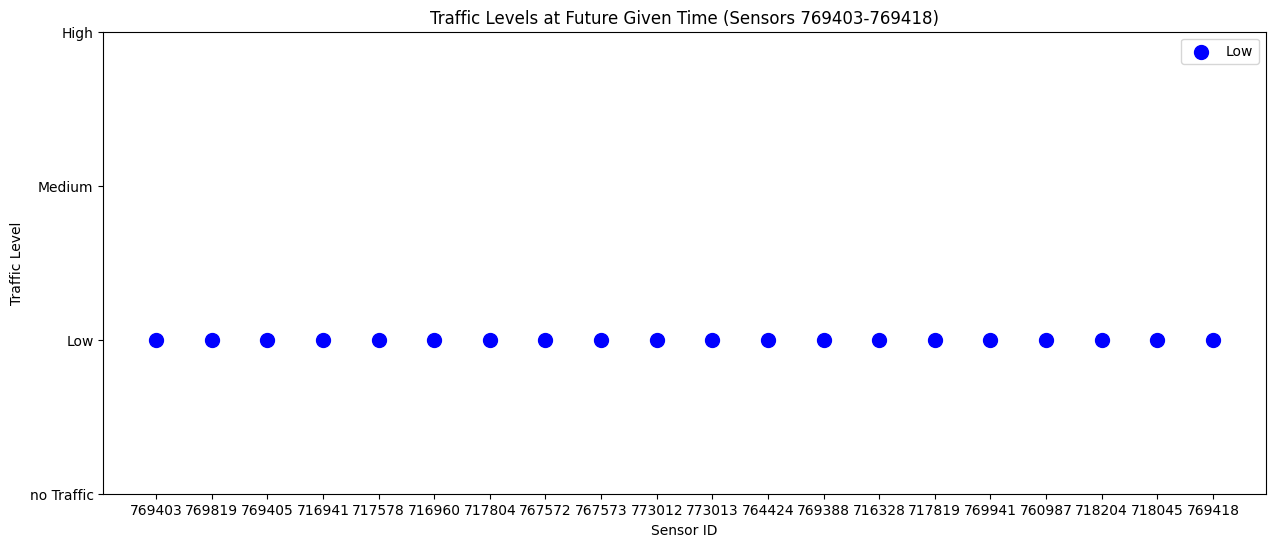

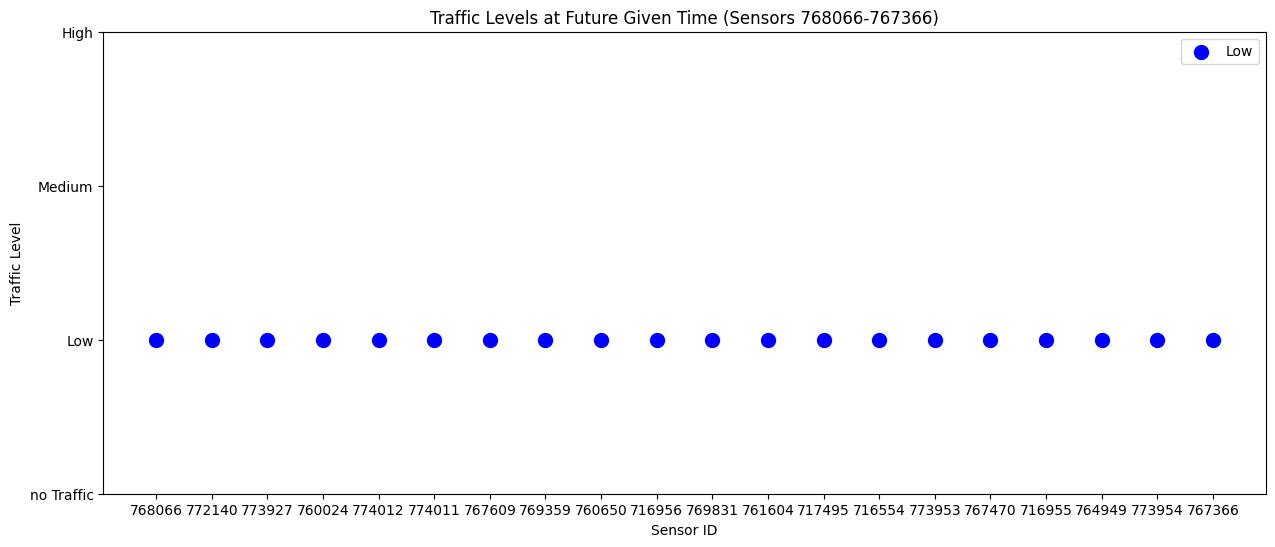

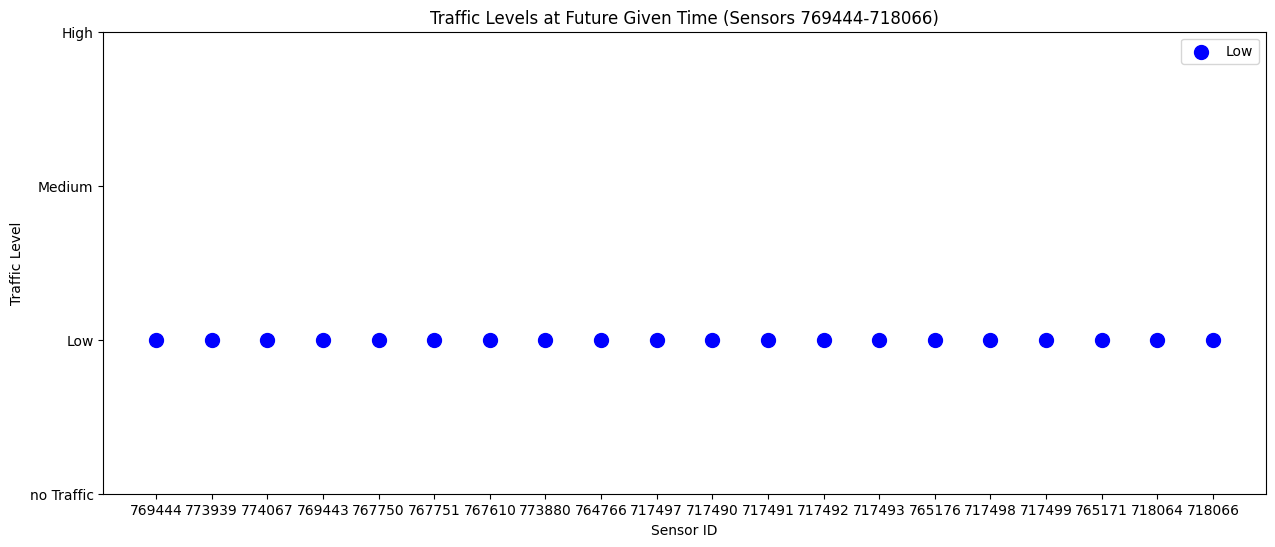

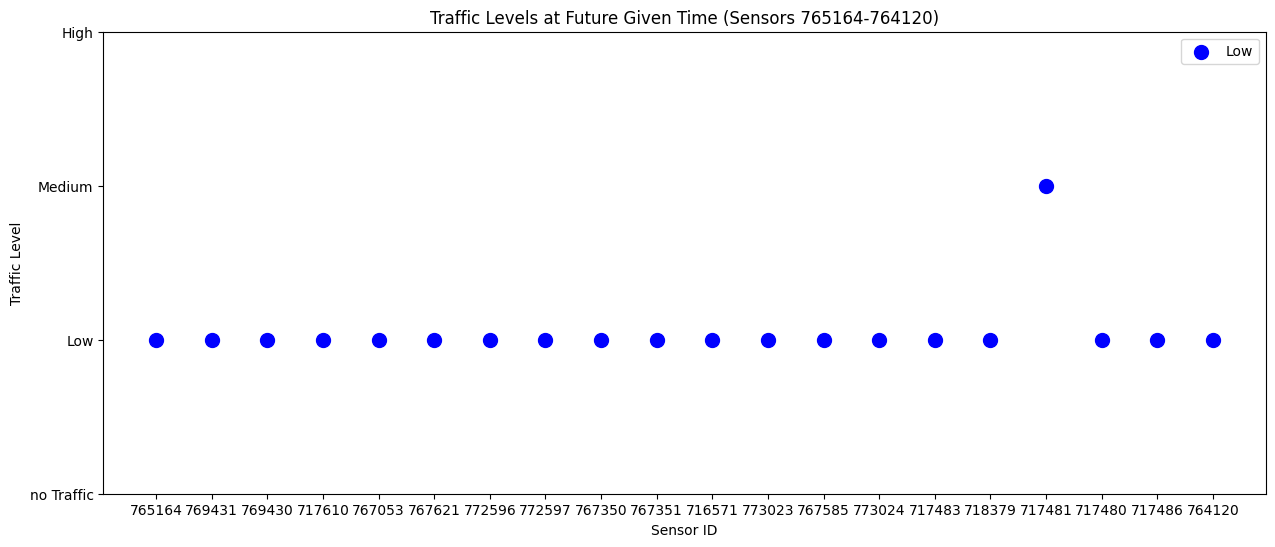

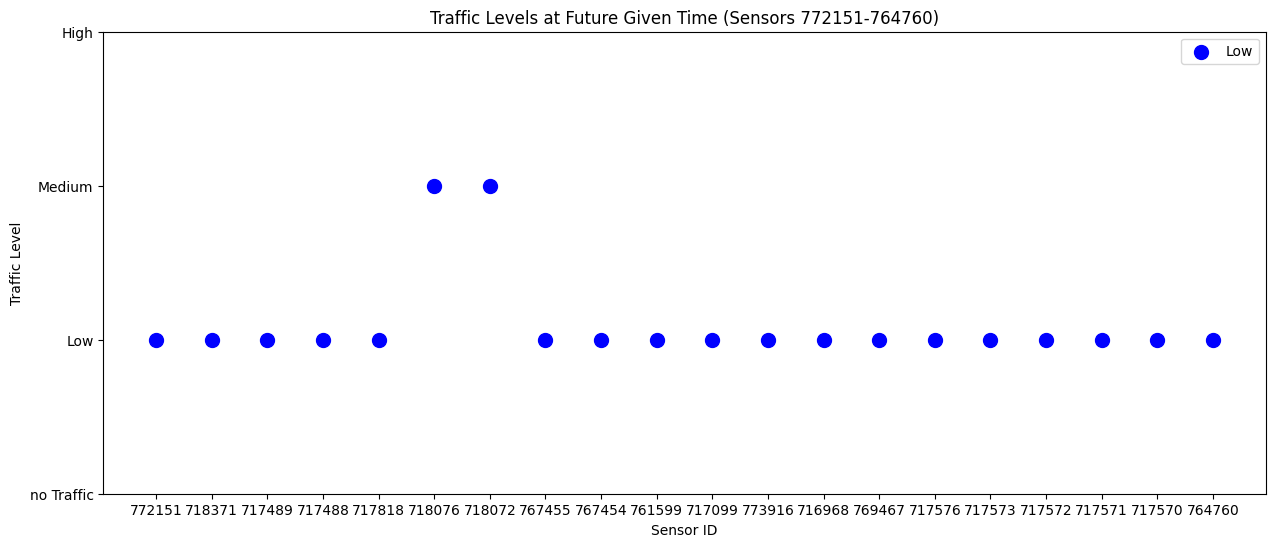

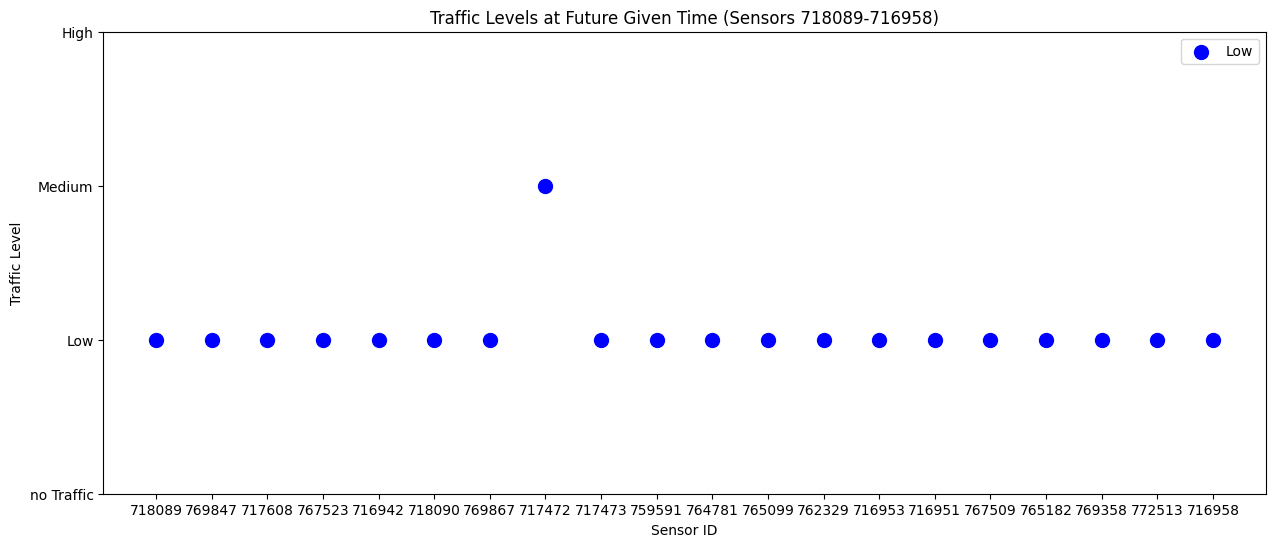

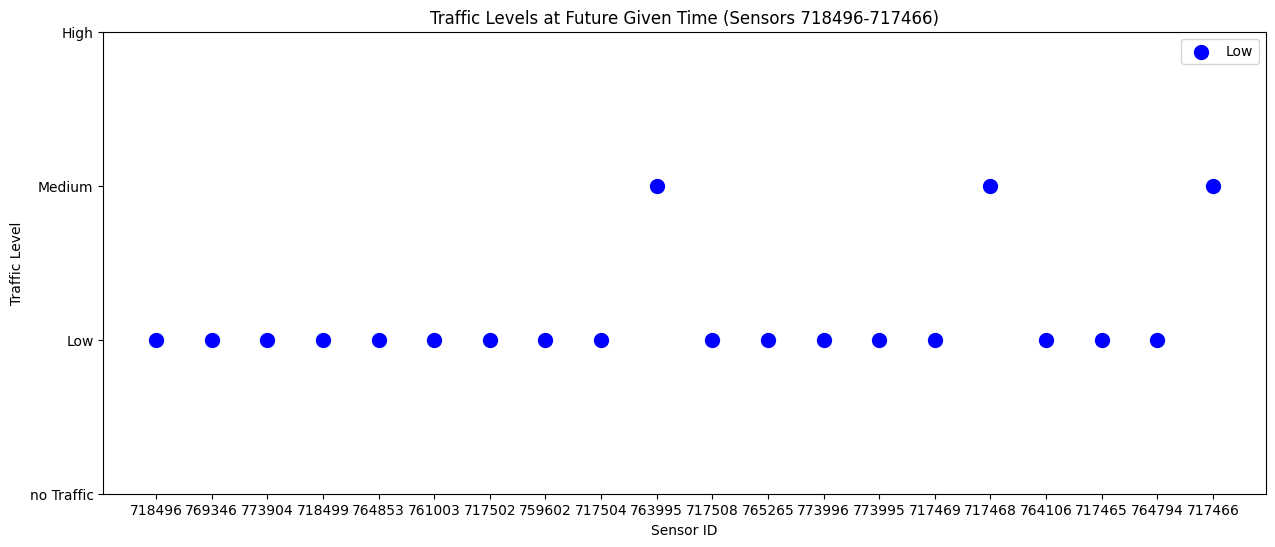

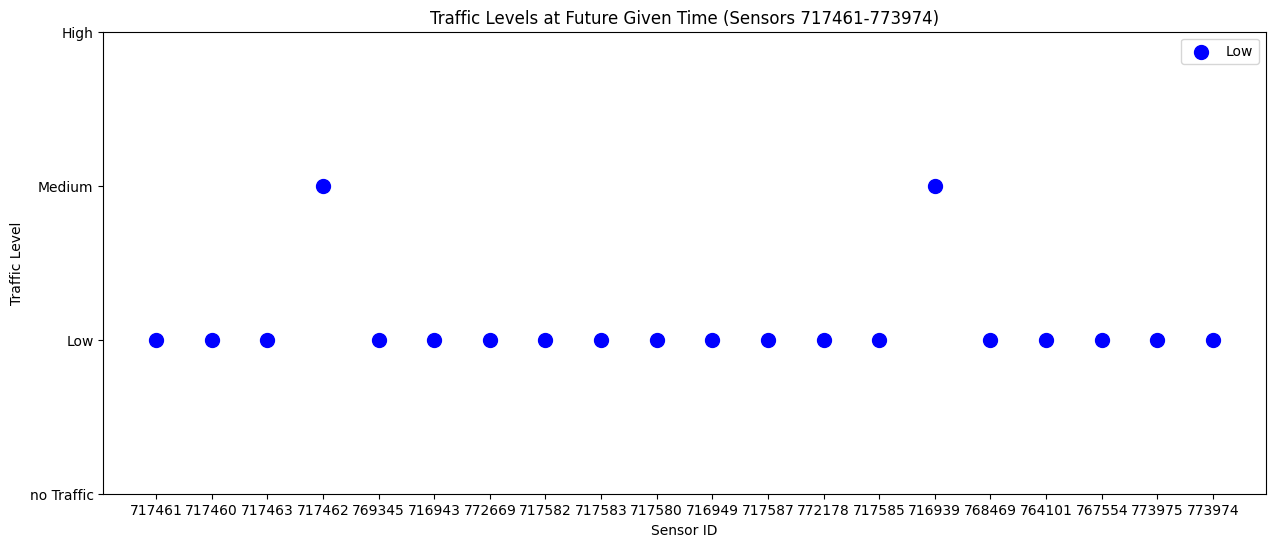

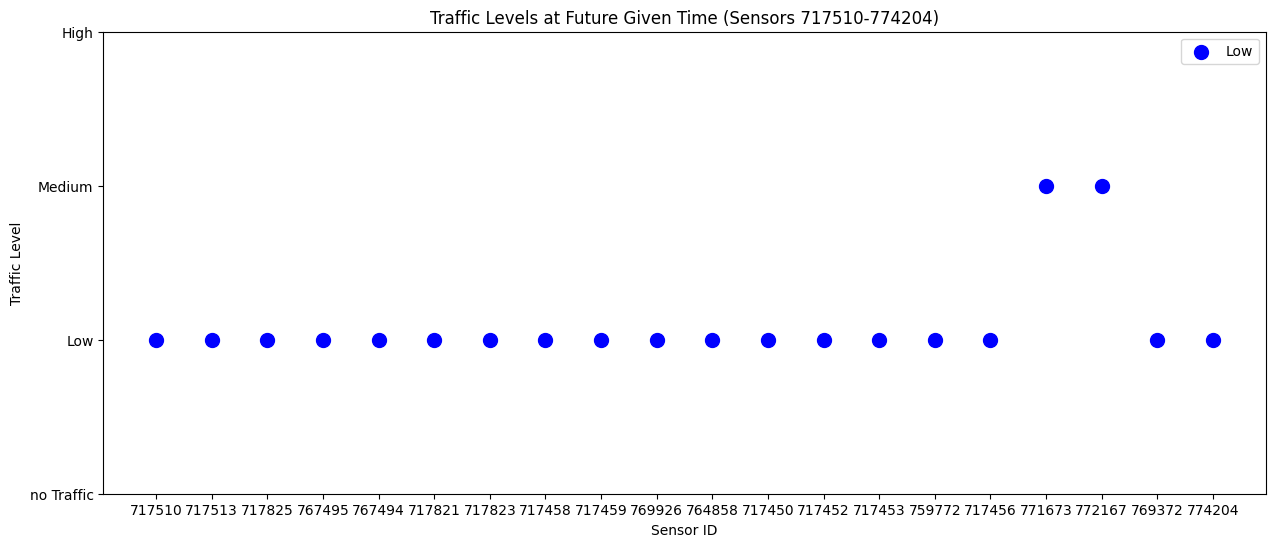

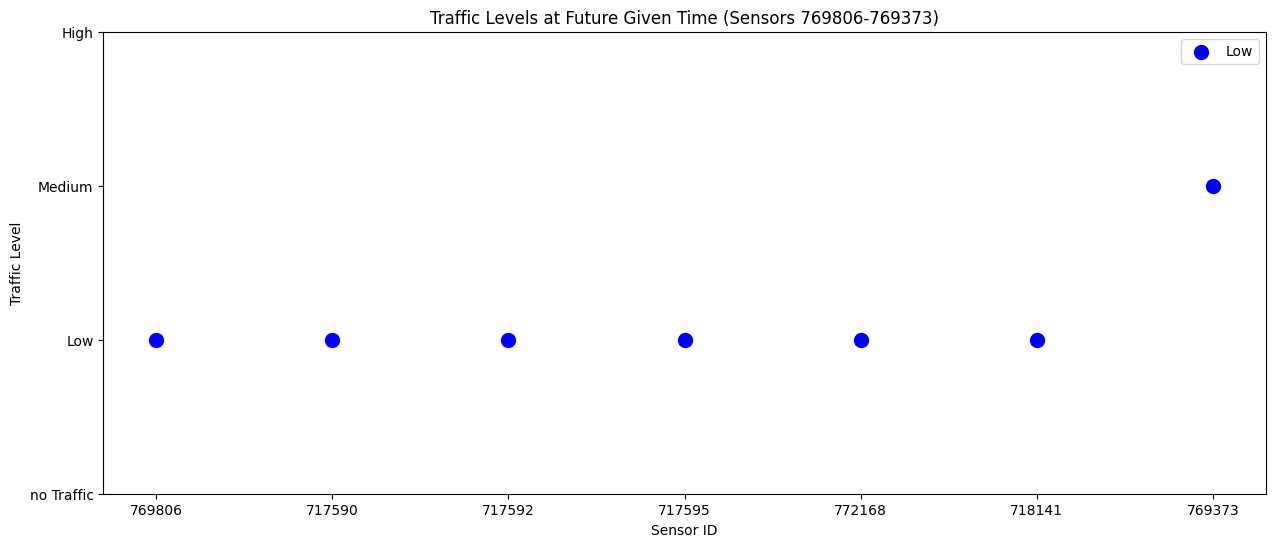

In [50]:
for i in range(0, len(test_df.columns), sensors_per_plot):
    sensor_group = test_df.columns[i: i + sensors_per_plot]
    future_traffic_levels_group = {sensor_id: future_traffic_levels[sensor_id] for sensor_id in sensor_group}
    plot_traffic_levels_group(sensor_group, future_traffic_levels_group, f"Traffic Levels at Future Given Time (Sensors {sensor_group[0]}-{sensor_group[-1]})")


In [51]:
def plot_sensor_positions_on_map(sensor_positions, traffic_levels):
    # Create a map centered at the average latitude and longitude of the sensors
    avg_lat = sensor_positions["latitude"].mean()
    avg_lon = sensor_positions["longitude"].mean()
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)

    # Define colors for different traffic levels
    colors = {
        "no Traffic": "gray",
        "Low": "green",
        "Medium": "orange",
        "High": "red",
    }

    # Add markers for each sensor
    for idx, row in sensor_positions.iterrows():
        sensor_id = row["sensor_id"]
        lat = row["latitude"]
        lon = row["longitude"]
        level = traffic_levels[sensor_id]
        color = colors[level]

        folium.Marker(
            location=[lat, lon],
            icon=folium.Icon(color=color),
            tooltip=f"Sensor ID: {sensor_id}, Traffic: {level}",
        ).add_to(m)

    return m


In [52]:
# Read sensor positions from the file
sensor_positions = pd.read_csv("graph_sensor_locations.csv")

# Map sensor IDs to their index in the dataset
sensor_id_to_index = {sensor_id: idx for idx, sensor_id in enumerate(sensor_positions["sensor_id"])}



# Classify traffic levels for the given time index
traffic_levels_given_time = classify_traffic(
    sensor_positions["sensor_id"],
    traffic_speeds,
    low_threshold,
    medium_threshold,
    no_threshold,
)

# Plot the sensor positions with their traffic classification on a map
m = plot_sensor_positions_on_map(sensor_positions, traffic_levels_given_time)
m.save("sensor_positions_map.html")  # Save the map as an HTML file
m  # Display the map in the notebook


In [53]:
# Read sensor positions from the file
sensor_positions = pd.read_csv("graph_sensor_locations.csv")

# Map sensor IDs to their index in the dataset
sensor_id_to_index = {sensor_id: idx for idx, sensor_id in enumerate(sensor_positions["sensor_id"])}



# Classify traffic levels for the given time index
traffic_levels_given_time = classify_traffic(
    sensor_positions["sensor_id"],
    future_traffic_speeds,
    low_threshold,
    medium_threshold,
    no_threshold,
)

# Plot the sensor positions with their traffic classification on a map
m = plot_sensor_positions_on_map(sensor_positions, traffic_levels_given_time)
m.save("sensor_positions_map.html")  # Save the map as an HTML file
m  # Display the map in the notebook
